In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.base import BaseEstimator, TransformerMixin
import lightgbm as lgb
from catboost import CatBoostClassifier
import xgboost as xgb

In [3]:
class DataPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, target_variable, predictors):
        self.target_variable = target_variable
        self.predictors = predictors
        self.scaler = StandardScaler()
        self.encoder = OneHotEncoder(handle_unknown='ignore')
        
    def fit(self, X, y=None):
        self.encoder.fit(X[self.predictors])
        return self

    def transform(self, X, y=None):
        X_encoded = self.encoder.transform(X[self.predictors])
        return X_encoded

    def get_feature_names(self):
        return self.encoder.get_feature_names_out(self.predictors)

class Modeling(DataPreprocessor):
    def __init__(self, file_path, target_variable, predictors):
        super().__init__(target_variable, predictors)
        self.data = pd.read_csv(file_path)
        self.data[self.target_variable] = self.data[self.target_variable].replace({1: 0, 2: 1})
        self.X = self.data[self.predictors]
        self.y = self.data[self.target_variable]
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.3, random_state=42)
        self.X_train = self.fit_transform(self.X_train)
        self.X_test = self.transform(self.X_test)

    def train_logistic_regression(self):
        model = LogisticRegression(max_iter=500)
        model.fit(self.X_train, self.y_train)
        return model
    
    def train_decision_tree(self):
        model = DecisionTreeClassifier(max_depth=5, min_samples_split=10)
        model.fit(self.X_train, self.y_train)
        return model
    
    def train_random_forest(self):
        model = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)
        model.fit(self.X_train, self.y_train)
        return model
    
    def train_lightgbm(self):
        model = lgb.LGBMClassifier(n_estimators=50, max_depth=10, num_leaves=32, random_state=42)
        model.fit(self.X_train, self.y_train)
        return model
    
    def train_catboost(self):
        model = CatBoostClassifier(iterations=100, depth=5, learning_rate=0.1, verbose=0)
        model.fit(self.X_train, self.y_train)
        return model
    
    def train_xgboost(self):
        model = xgb.XGBClassifier(n_estimators=50, max_depth=10, random_state=42, use_label_encoder=False, eval_metric='logloss')
        model.fit(self.X_train, self.y_train)
        return model

    def train_voting_classifier(self):
        # Train top three models
        lr = self.train_logistic_regression()
        rf = self.train_random_forest()
        lgbm = self.train_lightgbm()
        model = VotingClassifier(estimators=[
            ('lr', lr),
            ('rf', rf),
            ('lgbm', lgbm)
        ], voting='soft')
        model.fit(self.X_train, self.y_train)
        return model

class Evaluation(Modeling):
    def __init__(self, file_path, target_variable, predictors):
        super().__init__(file_path, target_variable, predictors)

    def evaluate_model(self, model):
        y_pred = model.predict(self.X_test)
        y_prob = model.predict_proba(self.X_test)[:, 1] if hasattr(model, "predict_proba") else None

        # Confusion Matrix
        cm = confusion_matrix(self.y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

        # Classification Report
        print(classification_report(self.y_test, y_pred))

        # Feature Importance
        if hasattr(model, "feature_importances_"):
            importance = model.feature_importances_
            if isinstance(model, xgb.XGBClassifier):
                features = model.get_booster().feature_names
            else:
                features = self.get_feature_names()
            indices = np.argsort(importance)[-20:]
            plt.figure(figsize=(10, 6))
            plt.title('Top 20 Feature Importances')
            plt.barh(range(len(indices)), importance[indices], color='b', align='center')
            plt.yticks(range(len(indices)), [features[i] for i in indices])
            plt.xlabel('Relative Importance')
            plt.show()
        else:
            print("Model does not have feature importances")

        # ROC Curve
        if y_prob is not None:
            fpr, tpr, _ = roc_curve(self.y_test, y_prob)
            roc_auc = auc(fpr, tpr)
            plt.figure()
            plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic')
            plt.legend(loc="lower right")
            plt.show()
        else:
            print("Model does not have predict_proba method")


[LightGBM] [Info] Number of positive: 389785, number of negative: 524894
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 176
[LightGBM] [Info] Number of data points in the train set: 914679, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.426144 -> initscore=-0.297601
[LightGBM] [Info] Start training from score -0.297601


/home/oro/DataScience/dsc-venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:14:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 389785, number of negative: 524894
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 176
[LightGBM] [Info] Number of data points in the train set: 914679, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.426144 -> initscore=-0.297601
[LightGBM] [Info] Start training from score -0.297601
[LightGBM] [Info] Number of positive: 389785, number of negative: 524894
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 176
[LightGBM] [Info] Number of data points in the train set: 914679, number of used features: 88
[LightGBM] [In

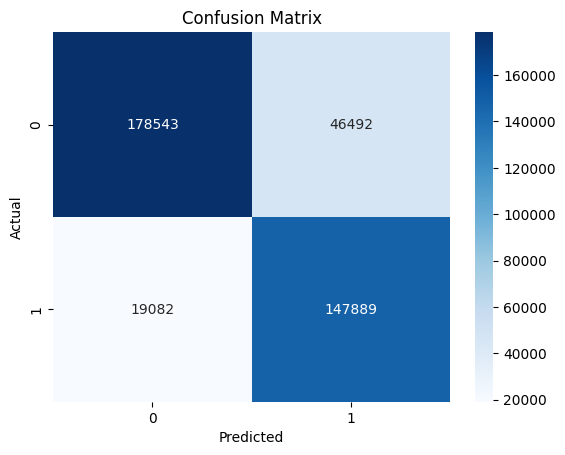

              precision    recall  f1-score   support

           0       0.90      0.79      0.84    225035
           1       0.76      0.89      0.82    166971

    accuracy                           0.83    392006
   macro avg       0.83      0.84      0.83    392006
weighted avg       0.84      0.83      0.83    392006

Model does not have feature importances


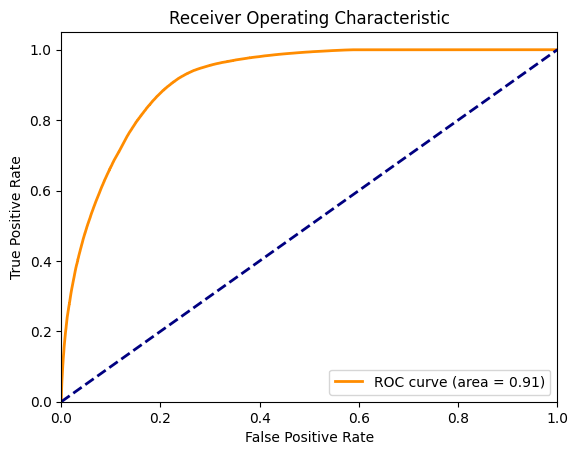



Evaluating Decision Tree


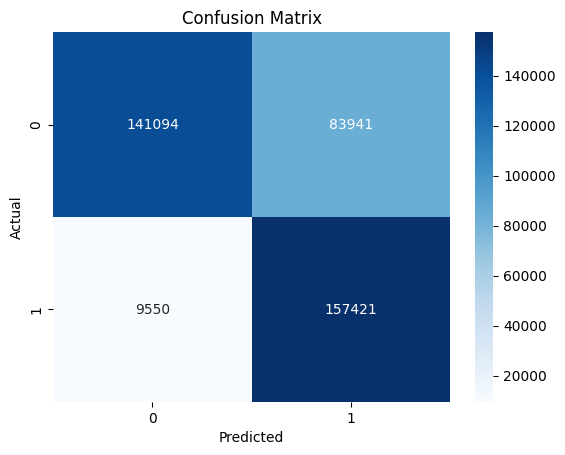

              precision    recall  f1-score   support

           0       0.94      0.63      0.75    225035
           1       0.65      0.94      0.77    166971

    accuracy                           0.76    392006
   macro avg       0.79      0.78      0.76    392006
weighted avg       0.82      0.76      0.76    392006



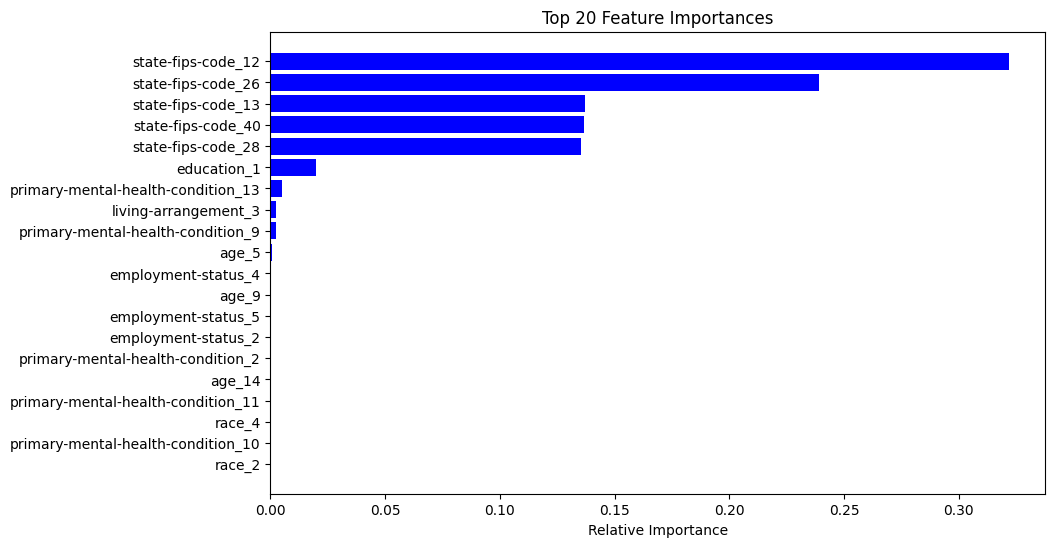

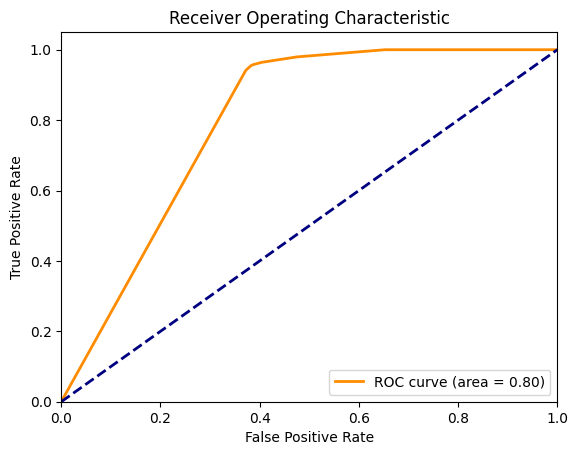



Evaluating Random Forest


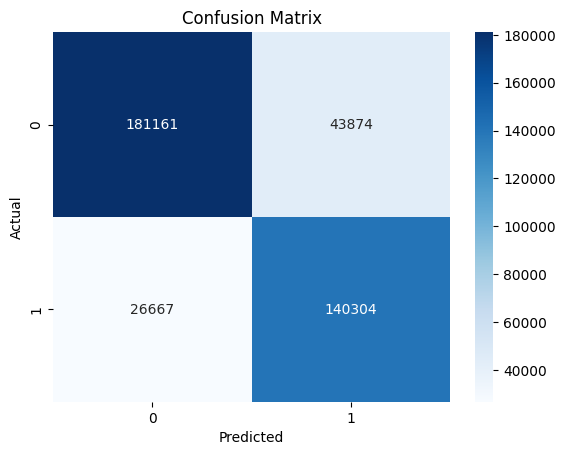

              precision    recall  f1-score   support

           0       0.87      0.81      0.84    225035
           1       0.76      0.84      0.80    166971

    accuracy                           0.82    392006
   macro avg       0.82      0.82      0.82    392006
weighted avg       0.82      0.82      0.82    392006



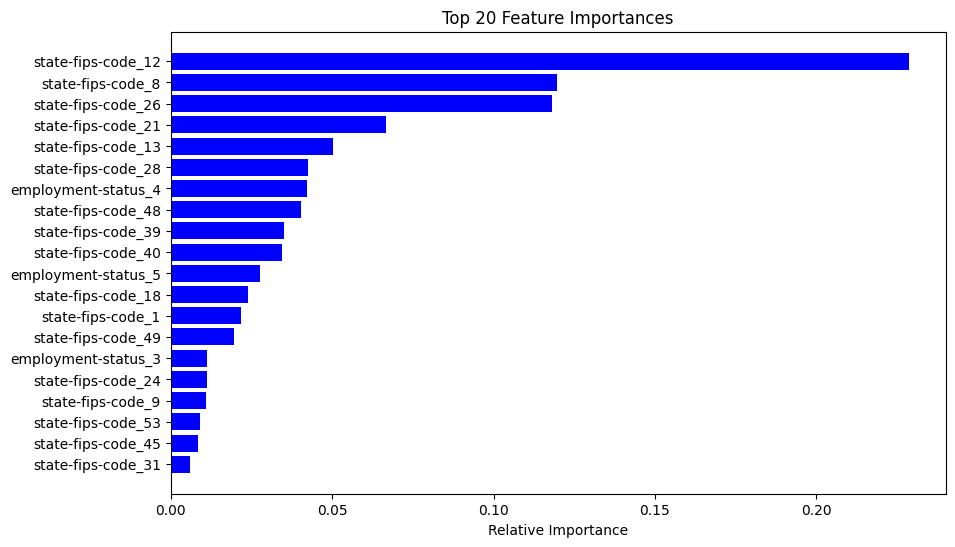

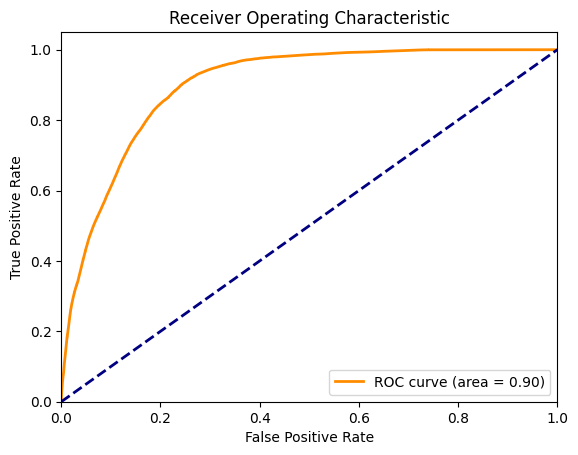



Evaluating LightGBM


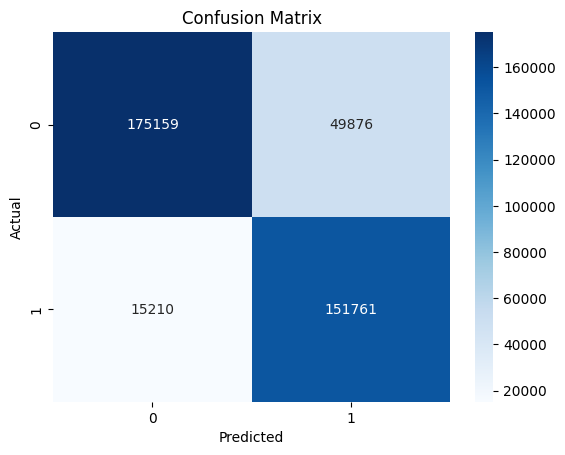

              precision    recall  f1-score   support

           0       0.92      0.78      0.84    225035
           1       0.75      0.91      0.82    166971

    accuracy                           0.83    392006
   macro avg       0.84      0.84      0.83    392006
weighted avg       0.85      0.83      0.83    392006



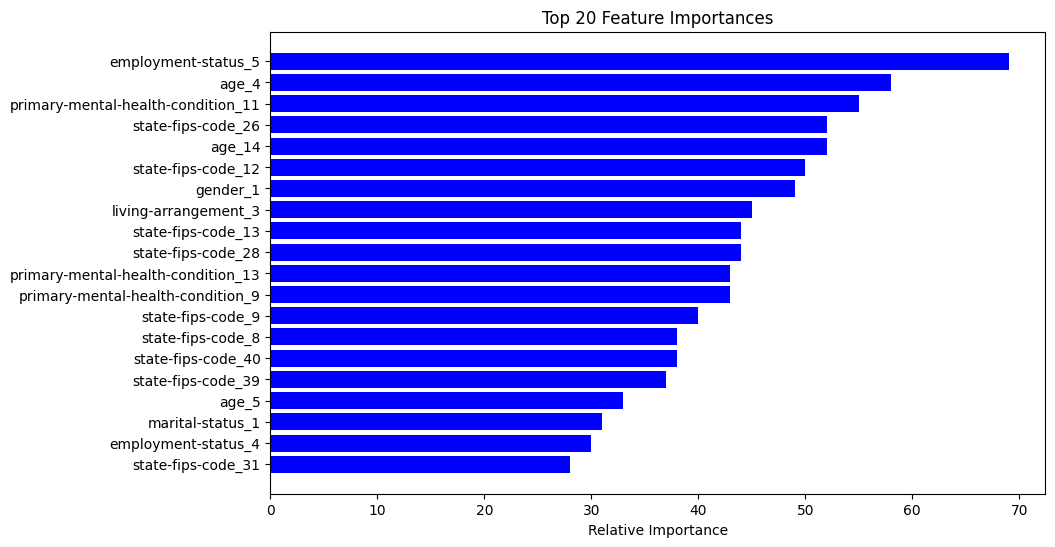

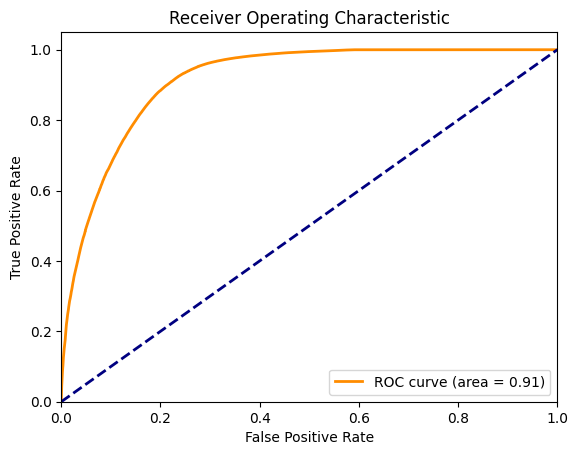



Evaluating CatBoost


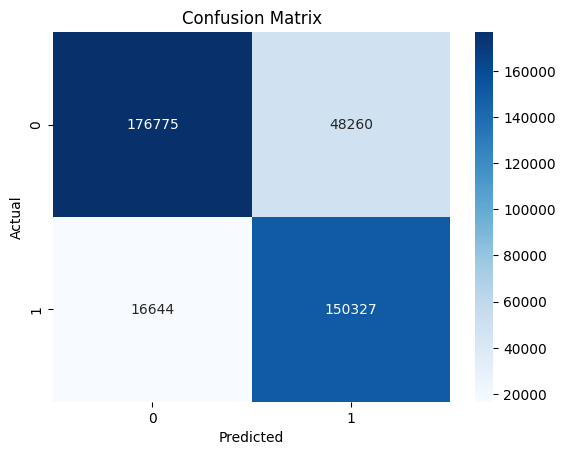

              precision    recall  f1-score   support

           0       0.91      0.79      0.84    225035
           1       0.76      0.90      0.82    166971

    accuracy                           0.83    392006
   macro avg       0.84      0.84      0.83    392006
weighted avg       0.85      0.83      0.84    392006



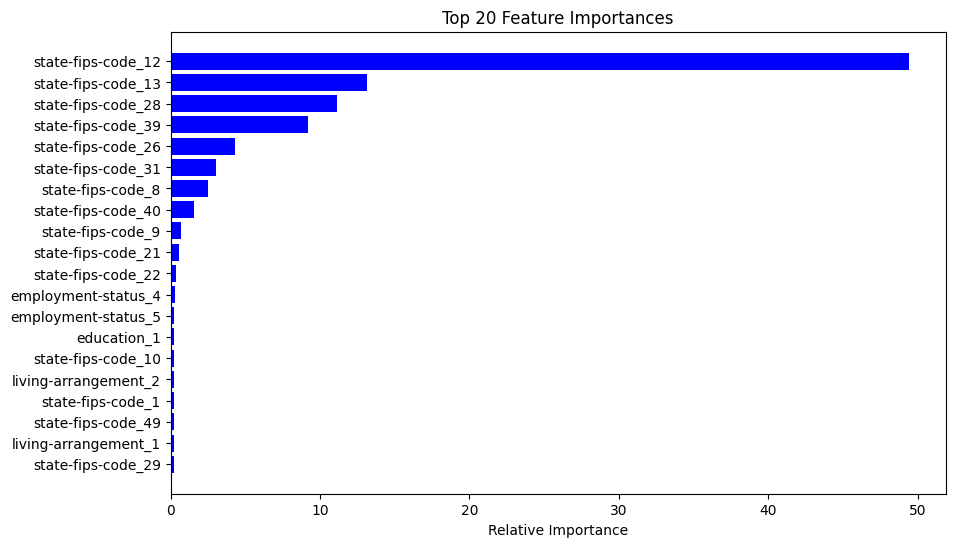

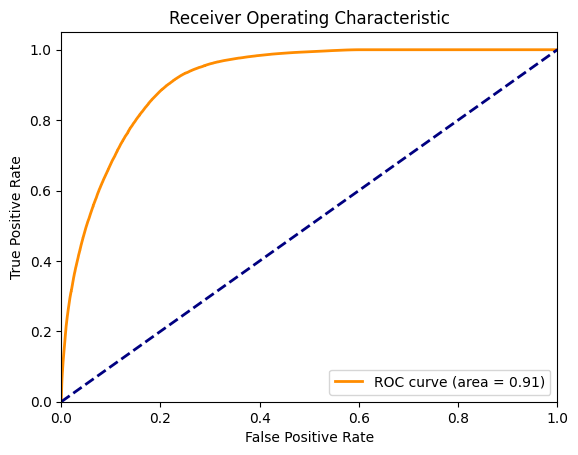



Evaluating XGBoost


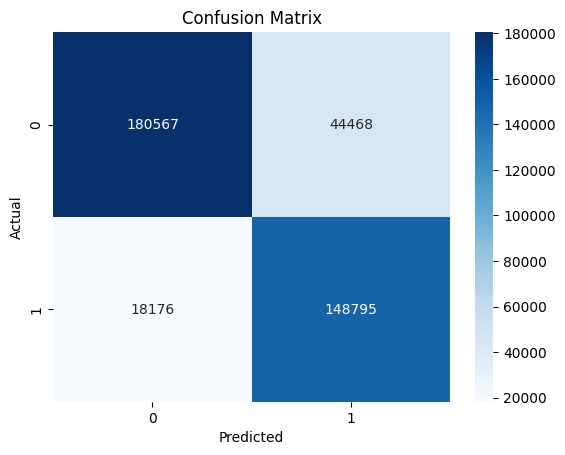

              precision    recall  f1-score   support

           0       0.91      0.80      0.85    225035
           1       0.77      0.89      0.83    166971

    accuracy                           0.84    392006
   macro avg       0.84      0.85      0.84    392006
weighted avg       0.85      0.84      0.84    392006



TypeError: 'NoneType' object is not subscriptable

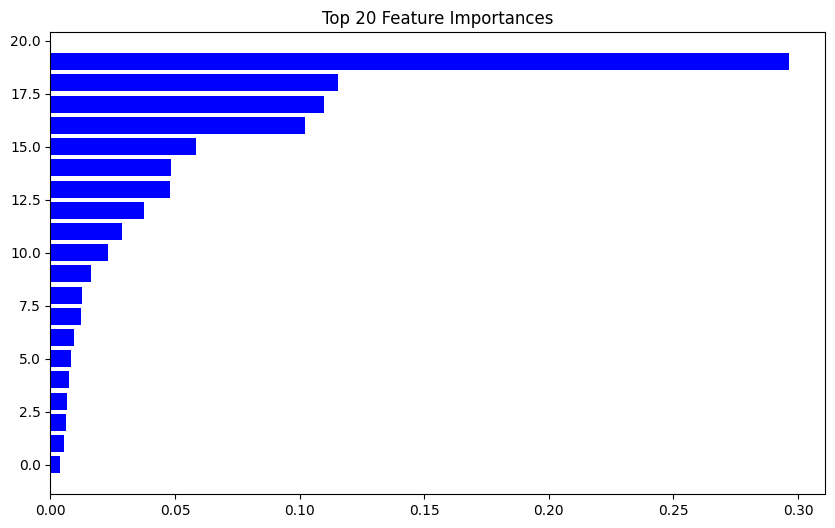

In [4]:
file_path = 'data/cleaned_data.csv'
target_variable = 'target-variable'
predictors = [
    'primary-mental-health-condition', 'age', 'race', 'gender', 
    'marital-status', 'education', 'employment-status', 
    'living-arrangement', 'veteran-status', 'state-fips-code'
]

evaluation = Evaluation(file_path, target_variable, predictors)

models = {
    "Logistic Regression": evaluation.train_logistic_regression(),
    "Decision Tree": evaluation.train_decision_tree(),
    "Random Forest": evaluation.train_random_forest(),
    "LightGBM": evaluation.train_lightgbm(),
    "CatBoost": evaluation.train_catboost(),
    "XGBoost": evaluation.train_xgboost(),
    "Voting Classifier": evaluation.train_voting_classifier()
}

for model_name, model in models.items():
    print(f"Evaluating {model_name}")
    evaluation.evaluate_model(model)
    print("\n" + "="*80 + "\n")
